In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [13]:
import matplotlib.pyplot as plt  

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [16]:
data = 'https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AER_credit_card_data.csv'

In [18]:
!/opt/homebrew/bin/wget $data

--2022-09-27 20:27:16--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AER_credit_card_data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 73250 (72K) [text/plain]
Saving to: ‘AER_credit_card_data.csv’

AER_credit_card_dat 100%[===================>]  71.53K  --.-KB/s    in 0.01s   

2022-09-27 20:27:16 (6.52 MB/s) - ‘AER_credit_card_data.csv’ saved [73250/73250]



In [19]:
df = pd.read_csv('AER_credit_card_data.csv')

In [80]:
df.head?

In [22]:
categorical = list(df.dtypes[df.dtypes == 'object'].index)

In [24]:
df.card = (df.card == 'yes').astype(int)

In [82]:
df.head()

,card,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active
0,1,0,37.66667,4.5200,0.033270,124.983300,yes,no,3,54,1,12
1,1,0,33.25000,2.4200,0.005217,9.854167,no,no,3,34,1,13
2,1,0,33.66667,4.5000,0.004156,15.000000,yes,no,4,58,1,5
3,1,0,30.50000,2.5400,0.065214,137.869200,no,no,0,25,1,7
4,1,0,32.16667,9.7867,0.067051,546.503300,yes,no,2,64,1,5


In [26]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [28]:
categorical = list(df.dtypes[df.dtypes == 'object'].index)

In [52]:
numerical = list(df.dtypes[df.dtypes == 'int64'].index)

In [53]:
numerical2 = list(df.dtypes[df.dtypes == 'float64'].index)

In [55]:
numerical

['card', 'reports', 'dependents', 'months', 'majorcards', 'active']

In [56]:
numerical += numerical2

In [91]:
del numerical[0]

In [58]:
y_train = df_train.card.values
y_val = df_val.card.values
y_test = df_test.card.values

del df_train['card']
del df_val['card']
del df_test['card']



# Question 1

ROC AUC could also be used to evaluate feature importance of numerical variables.

Let's do that

    For each numerical variable, use it as score and compute AUC with the card variable.
    Use the training dataset for that.

If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. -df_train['expenditure'])

AUC can go below 0.5 if the variable is negatively correlated with the target varialble. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

    reports
    dependents
    active
    share
Answer: share


In [93]:
from sklearn.metrics import roc_auc_score

for feature in numerical:
    score = roc_auc_score(y_train, df_train[feature])
    if score < 0.5:
        score = roc_auc_score(y_train, -df_train[feature])
    print(f'{feature:>12}: {score}')
 

     reports: 0.7166629860689376
  dependents: 0.5327757227773791
      months: 0.5294217780967629
  majorcards: 0.5343859842838476
      active: 0.6043173411362006
         age: 0.5240020979407055
      income: 0.5908049467233478
       share: 0.989183643423692
 expenditure: 0.991042345276873


In [95]:
df_train.head()

,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active
1105,3,40.50000,4.0128,0.000299,0.00000,no,no,1,12,1,17
431,1,32.33333,6.0000,0.000200,0.00000,yes,no,4,18,1,4
407,1,29.16667,2.2000,0.038205,69.79333,no,no,0,49,1,7
1217,1,54.66667,7.2900,0.106536,647.20670,yes,no,2,78,1,9
1133,0,25.00000,3.3984,0.000353,0.00000,yes,no,2,29,0,4


# Question 2

What's the AUC of this model on the validation dataset? (round to 3 digits)

    0.615
    0.515
    0.715
    0.995
Answer: 0.995

In [100]:
# train the model wtih one-hot encoding
dv = DictVectorizer(sparse=False)
dicts_train = df_train.to_dict(orient='records')
dicts_val = df_val.to_dict(orient='records')
dv.fit(dicts_train)
X_train = dv.transform(dicts_train)
X_val = dv.transform(dicts_val)
model = LogisticRegression(solver="liblinear", C=1.0, max_iter=1000)
model.fit(X_train, y_train)
y_pred = model.predict_proba(X_val)[:, 1]
score = roc_auc_score(y_val, y_pred).round(3)
score

0.995

# Question 3

Now let's compute precision and recall for our model.

    Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
    For each threshold, compute precision and recall
    Plot them

At which threshold precision and recall curves intersect?

    0.1
    0.3
    0.6
    0.8
Answer: 0.3

In [103]:
# confusion matrix
scores = []

thresholds = np.linspace(0, 1, 101)

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    scores.append((t, tp, fp, fn, tn))

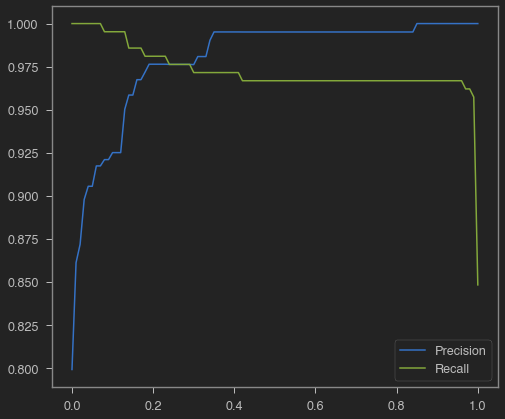

In [107]:
# plotting precision and recall
columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(scores, columns=columns)


df_scores['Precision'] = df_scores.tp / (df_scores.tp + df_scores.fp)
df_scores['Recall'] = df_scores.tp / (df_scores.tp + df_scores.fn)

plt.plot(df_scores.threshold, df_scores['Precision'], label='Precision')
plt.plot(df_scores.threshold, df_scores['Recall'], label='Recall')
plt.legend()



# Question 4

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

F1 = 2 * P * R / (P + R)

Where P is precision and R is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

    0.1
    0.4
    0.6
    0.7
Answer: 0.4

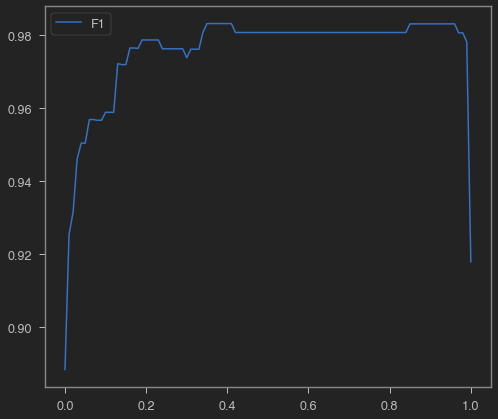

In [109]:
f1_scores = []

thresholds = np.linspace(0, 1, 101)

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    P = tp / (tp + fp)
    R = tp / (tp + fn)
    F1 = 2 * P * R / (P + R)
    f1_scores.append((t, F1, P, R))
    
# plotting F1
columns = ['threshold', 'F1', 'Precision', 'Recall']
df_scores = pd.DataFrame(f1_scores, columns=columns)

plt.plot(df_scores.threshold, df_scores['F1'], label='F1')
plt.legend()




    

# Question 5

Use the KFold class from Scikit-Learn to evaluate our model on 5 different folds:

KFold(n_splits=5, shuffle=True, random_state=1)

    Iterate over different folds of df_full_train
    Split the data into train and validation
    Train the model on train with these parameters: LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    Use AUC to evaluate the model on validation

How large is standard devidation of the AUC scores across different folds?

    0.003
    0.014
    0.09
    0.24
Answer: 0.003

In [123]:
from sklearn.model_selection import KFold

def train(df_train, y_train, C=1.0):
    dicts = df_train.to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)

    return dv, model

def predict(df, dv, model):
    dicts = df.to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

scores = []

kfold = KFold(n_splits=5, shuffle=True, random_state=1)

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.card.values
    y_val = df_val.card.values

    del df_train['card']
    del df_val['card']

    dv, model = train(df_train, y_train)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

print('%.3f +- %.3f' % (np.mean(scores), np.std(scores)))



0.996 +- 0.003


# Question 6

Now let's use 5-Fold cross-validation to find the best parameter C

    Iterate over the following C values: [0.01, 0.1, 1, 10]
    Initialize KFold with the same parameters as previously
    Use these parametes for the model: LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

Which C leads to the best mean score?

    0.01
    0.1
    1
    10

If you have ties, select the score with the lowest std. If you still have ties, select the smallest C

Answer: 1

In [124]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

for C in [0.01, 0.1, 1, 10]:
    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.card.values
        y_val = df_val.card.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print(f'C=%4s, %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

C=0.01, 0.993 +- 0.005
C= 0.1, 0.999 +- 0.001
C=   1, 1.000 +- 0.000
C=  10, 1.000 +- 0.000
